# Large-Scale Dataset Pruning with Dynamic Uncertainty for MNIST

Implementation according to "Large-scale Dataset Pruning with Dynamic Uncertainty". (https://arxiv.org/abs/2306.05175)

Check out "../RESULTS.md" to read more about archived performance.

Check out "../models" for the trained models.

**Objective:**

    "Implement data pruning using the dynamic uncertainty score on the MNIST dataset and train a model with 25% and 50% pruning (i.e., 25% or 50% of the data is removed for the final training using the calculated pruning scores). Compare your implementation with random subsampling of the data. Additionally, implement the following custom dynamic uncertainty score U(x) = abs(DFT(x)), where DFT is the Discrete Fourier Transform and abs takes the magnitude of the frequency spectrum. Consider the following: Do we need every value of the DFT, or can we remove some and get the same result? If we only want to consider the dynamics, which values do we need to remove? The task is to implement the dynamic uncertainty score and explore it. As, the score are changing, you should evaluate the DFT of the dynamic uncertainty."

In [1]:
# Torch
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader, Subset

# Torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

# Numpy
import numpy as np

# TQDM for progressbars
from tqdm import tqdm

# For fancy plots 
import matplotlib.pyplot as plt

/home/linus/miniconda3/envs/adl4r/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Configuration

In [10]:
batch_size = 32
pruning_ratio = 0.5
epochs = 15
crit = nn.CrossEntropyLoss()
J = 5 # J < epochs

# Use cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


---

In [3]:
# Eval accuracy of a given net on a given loader
def eval_acc(net : nn.Module, loader : DataLoader) -> float:
    net.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [4]:
# Train network
def train(net : nn.Module, epochs: int, trainloader: DataLoader, valloader : DataLoader, lr : float = 0.001) -> torch.nn.Module:
    optimizer = AdamW(net.parameters(), lr=lr)
    for epoch in range(epochs):
        total_loss = 0.0
        for inputs, labels in tqdm(trainloader, desc=f'Epoch {epoch + 1}/{epochs}'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = crit(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Epoch loss
        average_loss = total_loss / (trainloader.batch_size*len(trainloader))
        print(f'Epoch {epoch + 1}/{epochs}, Average Loss: {average_loss:.4f}')

        # Estimate Train and validation accuracy
        print(f'Train Accuracy: {eval_acc(net=net, loader=trainloader) * 100:.2f}%')
        print(f'Validation Accuracy: {eval_acc(net=net, loader=valloader) * 100:.2f}%')
    return net

---

Build Model

In [37]:
# Simple CNN in model.py
from model import CNN
    
# Test model 
x_random = torch.randn((2,1,28,28))
net = CNN()
print(net(x_random))
del net

tensor([[0.0989, 0.1312, 0.0885, 0.1102, 0.1117, 0.1059, 0.0658, 0.0794, 0.1023,
         0.1062],
        [0.0998, 0.1023, 0.0818, 0.1429, 0.1199, 0.0849, 0.0711, 0.0950, 0.0880,
         0.1143]], grad_fn=<SoftmaxBackward0>)


Load dataset

In [6]:
transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.1307,), (0.3081,)) # Mean and std of MNIST dataset
        ])

# Load train and testset from torchvision
trainset = MNIST(root='../data', train=True, download=True, transform=transform)
testset = MNIST(root='../data', train=False, download=True, transform=transform)

# Just shuffle once initially! Continous shuffling could lead to indexing problems for the pruning approach.
indices = torch.randperm(len(trainset))
train_size = int(0.8 * len(indices))
subset_size = int((1 - pruning_ratio) * train_size)

# Split Train in Train and Val
val_size = len(indices) - train_size
train_indices, val_indices = indices[:train_size], indices[train_size:]
train_subset = Subset(trainset, train_indices)
val_subset = Subset(trainset, val_indices)

trainloader = DataLoader(train_subset, batch_size=batch_size, shuffle=False)
valloader =  DataLoader(val_subset, batch_size=batch_size, shuffle=False)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [7]:
print(f"Trainset size: {train_size}")
print(f"Validation size: {val_size}")
print(f"Subset size: {subset_size}")
print(f"Teset size: {len(testset)}")

Trainset size: 48000
Validation size: 12000
Subset size: 24000
Teset size: 10000


---

**Baseline** (full dataset)

In [13]:
net_baseline = CNN()
net_baseline = net_baseline.to(device)
name_baseline = f"baseline_{epochs}"

In [ ]:
net_baseline = train(net=net_baseline, epochs=epochs, trainloader=trainloader, valloader=valloader)
net_baseline = train(net=net_baseline, epochs=epochs, trainloader=trainloader, valloader=valloader, lr=0.0001)
print(f'Test Accuracy: {eval_acc(net=net_baseline, loader=testloader) * 100:.2f}%')

In [176]:
torch.save(net_baseline.state_dict(), f"../models/{name_baseline}.pth")

---

**Random Subsampling**

In [177]:
net_subsampling = CNN()
net_subsampling = net_subsampling.to(device)
name_subsampling = f"subsampling_{pruning_ratio}_{epochs}"

In [178]:
# Create a new dataloader for the trainset with a SubsetRandomSampler that only selects from [:subset_size]
from torch.utils.data import SubsetRandomSampler
idxs = torch.randperm(train_size)[:subset_size]
sampler = SubsetRandomSampler(idxs)
randomsubsampledloader = DataLoader(trainloader.dataset, batch_size=batch_size, sampler=sampler)

In [ ]:
net_subsampling = train(net=net_subsampling, epochs=epochs, trainloader=randomsubsampledloader, valloader=valloader)
net_subsampling = train(net=net_subsampling, epochs=epochs, trainloader=randomsubsampledloader, valloader=valloader, lr=0.0001)
print(f'Test Accuracy: {eval_acc(net=net_subsampling, loader=testloader) * 100:.2f}%')

In [180]:
torch.save(net_subsampling.state_dict(), f"../models/{name_subsampling}.pth")

Test acc: 100%|██████████| 313/313 [00:03<00:00, 83.85it/s]

Test Accuracy: 98.43%


---

**With Pruning**

In [11]:
net_pruning = CNN()
optimizer_pruning = AdamW(net_pruning.parameters())

In [12]:
# Algorithm 1: Dataset pruning with dynamic uncertainty.
# Input: Trainingset - trainloader, pruning ratio: pruning_ratio
# Required Model: net_pruning, traing epochs: epochs, uncertainty window: J

# To track uncertainty
uncertainty_window = np.zeros((train_size, J)) # Uncertainty window
uncertainty_EQ2 = np.zeros((train_size, epochs-J+1)) # Uncertainty according to Eq.2
uncertainty = np.zeros(train_size) # Overall uncertainty according to Eq.3

# for k = 0, · · · , K − 1 do
for epoch in range(epochs):
    total_loss = 0.0
    idx = 0
    
    # Sample a batch B ∼ T.
    # for (xi, yi) ∈ B do:
    for inputs, labels in tqdm(trainloader, desc=f'Epoch {epoch + 1}/{epochs}'):
        optimizer_pruning.zero_grad()

        # Compute prediction P(yi, xi, θ) and loss ℓ(ϕθ(A(xi)), yi)
        outputs = net_pruning(inputs)
        loss = crit(outputs, labels)

        # Store window
        predicted_values = outputs[range(outputs.size(0)), labels]
        uncertainty_window[idx:idx+len(labels), epoch%J] = predicted_values.detach().numpy()
        idx += len(labels)

        # Update θ ← θ − η∇θL, where L =Σℓ(ϕθ(A(xi)),yi) / |B|
        loss.backward()
        optimizer_pruning.step()
        total_loss += loss.item()

    # if k ≥ J then
        # Compute uncertainty Uk−J (xi) using Eq. 2
    if epoch >= J-1:
            U_epoch = np.std(uncertainty_window, ddof=1, axis=1)
            uncertainty_EQ2[:, epoch-J+1] = U_epoch

    average_loss = total_loss / subset_size
    print(f'Epoch {epoch + 1}/{epochs}, Average Loss: {average_loss:.4f}')

# for (xi, yi) ∈ T do
    # Compute dynamic uncertainty U(xi) using Eq. 3
uncertainty = np.mean(uncertainty_EQ2, axis=1)

# Sort T in the descending order of U(·)
sorted_indices = np.argsort(uncertainty)[::-1]

# S ← front (1 − r) × |T | samples in the sorted T
subset_indices = sorted_indices[:int(len(sorted_indices)*(1-pruning_ratio))]

# Output: Pruned dataset S
train_dynamic_uncertainty_subset = Subset(dataset=trainloader.dataset, indices=subset_indices)

Epoch 1/15:   1%|          | 8/1500 [00:00<00:43, 34.08it/s]

Epoch 1/15: 100%|██████████| 1500/1500 [00:41<00:00, 36.24it/s]


Epoch 1/15, Average Loss: 0.0959


Epoch 2/15: 100%|██████████| 1500/1500 [00:34<00:00, 43.83it/s]


Epoch 2/15, Average Loss: 0.0931


Epoch 3/15: 100%|██████████| 1500/1500 [00:37<00:00, 39.87it/s]


Epoch 3/15, Average Loss: 0.0926


Epoch 4/15: 100%|██████████| 1500/1500 [00:38<00:00, 39.21it/s]


Epoch 4/15, Average Loss: 0.0925


Epoch 5/15: 100%|██████████| 1500/1500 [00:47<00:00, 31.77it/s]


Epoch 5/15, Average Loss: 0.0923


Epoch 6/15: 100%|██████████| 1500/1500 [00:42<00:00, 35.46it/s]


Epoch 6/15, Average Loss: 0.0922


Epoch 7/15: 100%|██████████| 1500/1500 [00:39<00:00, 37.90it/s]


Epoch 7/15, Average Loss: 0.0921


Epoch 8/15: 100%|██████████| 1500/1500 [00:32<00:00, 45.52it/s]


Epoch 8/15, Average Loss: 0.0920


Epoch 9/15: 100%|██████████| 1500/1500 [00:43<00:00, 34.79it/s]


Epoch 9/15, Average Loss: 0.0920


Epoch 10/15: 100%|██████████| 1500/1500 [00:42<00:00, 35.24it/s]


Epoch 10/15, Average Loss: 0.0920


Epoch 11/15: 100%|██████████| 1500/1500 [00:35<00:00, 41.69it/s]


Epoch 11/15, Average Loss: 0.0919


Epoch 12/15: 100%|██████████| 1500/1500 [00:30<00:00, 49.67it/s]


Epoch 12/15, Average Loss: 0.0919


Epoch 13/15: 100%|██████████| 1500/1500 [00:33<00:00, 45.19it/s]


Epoch 13/15, Average Loss: 0.0919


Epoch 14/15: 100%|██████████| 1500/1500 [00:32<00:00, 45.79it/s]


Epoch 14/15, Average Loss: 0.0918


Epoch 15/15: 100%|██████████| 1500/1500 [00:39<00:00, 37.79it/s]

Epoch 15/15, Average Loss: 0.0918


In [28]:
net_pruning = CNN()
net_pruning = net_pruning.to(device)
name_pruning = f"pruning_{pruning_ratio}_{epochs}"
dynamic_uncertainty = DataLoader(train_dynamic_uncertainty_subset, batch_size=batch_size, shuffle=False)

In [ ]:
net_pruning = train(net=net_pruning, epochs=epochs, trainloader=dynamic_uncertainty, valloader=valloader)
net_pruning = train(net=net_pruning, epochs=epochs, trainloader=dynamic_uncertainty, valloader=valloader, lr=0.0001)
print(f'Test Accuracy: {eval_acc(net=net_pruning, loader=testloader) * 100:.2f}%')

In [185]:
torch.save(net_pruning.state_dict(), f"../models/{name_pruning}.pth")

Test acc: 100%|██████████| 313/313 [00:05<00:00, 61.59it/s]

Test Accuracy: 97.93%


---

**Discrete Fourier Transform**

Additionally, implement the following custom dynamic uncertainty score U(x) = abs(DFT(x)), where DFT is the Discrete Fourier Transform and abs takes the magnitude of the frequency spectrum. Consider the following: Do we need every value of the DFT, or can we remove some and get the same result? If we only want to consider the dynamics, which values do we need to remove? "

The task is to implement the dynamic uncertainty score and explore it. As, the score are changing, you should evaluate the DFT of the dynamic uncertainty. Hope that makes it more clear.

In [26]:
print(f"Mean Uncertainties {np.mean(uncertainty_EQ2, axis=0)}")

Mean Uncertainties [0.03618682 0.01550272 0.01241558 0.01107075 0.01003913 0.00930863
 0.00845421 0.00798313 0.00759631 0.00695741 0.00664124]


**Do we need every value of the DFT, or can we remove some and get the same result?**

    Well, the first epochs are obviously noisy because the weights are initially random and the first uncertainty estimates are then not really reliable. Two possible solutions to this problem: warm start, separate updating and uncertainty estimation -> as in alternative_implementation.py

**If we only want to consider the dynamics, which values do we need to remove? "**

    Remove /filter the high frequency values.

In [33]:
uncertainty_fft = np.zeros(train_size) # Overall uncertainty according to specification
uncertainty_fft = np.absolute(np.fft.fft(uncertainty_EQ2, axis=1))
# uncertainty_fft = np.fft.fftshift(uncertainty_fft)

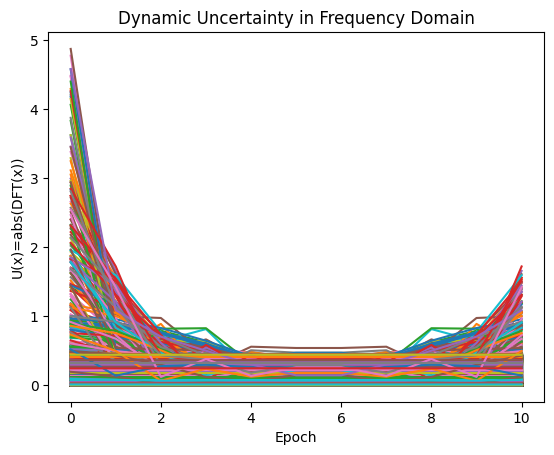

In [44]:
plt.plot(uncertainty_fft[:2000,:].T)
plt.title("Dynamic Uncertainty in Frequency Domain")
plt.xlabel("Epoch")
plt.ylabel("U(x)=abs(DFT(x))");